<a href="https://colab.research.google.com/github/quillaur/data_learning/blob/main/data_science/machine_learning/reinforcement_learning/dqn/cartpole_dqn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://alexandervandekleut.github.io/deep-q-learning/

In [62]:
!pip install gymnasium -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
from collections import deque, defaultdict
import random
import pandas as pd
import os
import time

In [66]:
class ReplayBuffer:
    def __init__(self, size=1000000):
        self.memory = deque(maxlen=size)
        
    def remember(self, s_t, a_t, r_t, s_t_next, trunc, d_t):
        self.memory.append((s_t, a_t, r_t, s_t_next, trunc, d_t))
        
    def sample(self, num=32):
        num = min(num, len(self.memory))
        return random.sample(self.memory, num)

In [67]:
class Agent:
    def __init__(self, state_shape=0, num_actions=0, num_envs=0, alpha=0.001, gamma=0.95, 
                 epsilon_i=1.0, epsilon_f=0.01, n_epsilon=0.1, hidden_sizes = [], model_path = ""):
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.n_epsilon = n_epsilon
        self.epsilon = epsilon_i
        self.discount_factor = gamma
        self.learning_rate = alpha

        self.num_actions = num_actions
        self.state_shape = state_shape
        self.num_envs = num_envs

        if model_path:
          self.Q = self.load_model(model_path)
        else:
          self.Q = self.create_model(hidden_sizes)
          # target network
          self.Q_ = self.create_model(hidden_sizes)
          self.optimizer = tf.keras.optimizers.Adam(alpha)
    
    def create_model(self, hidden_sizes):
      model = tf.keras.models.Sequential()
      model.add(tf.keras.layers.Input(shape=self.state_shape))
      for size in hidden_sizes:
          model.add(tf.keras.layers.Dense(size, activation='relu', use_bias='false', kernel_initializer='he_uniform', dtype='float64'))
      model.add(tf.keras.layers.Dense(self.num_actions, activation="linear", use_bias='false', kernel_initializer='zeros', dtype='float64'))

      return model
    
    def load_model(self, model_path):
      return tf.keras.models.load_model(model_path)
    
    def synchronize(self):
        self.Q_.set_weights(self.Q.get_weights())

    def explore_or_act(self, s_t):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions, size=self.num_envs)

        preds = self.Q.predict(s_t, verbose=0)
        # print(preds.shape)
        return np.argmax(preds, axis=1)
    
    def act(self, states):
      preds = self.Q.predict(states, verbose=0)
      return np.argmax(preds, axis=1)
    
    def decay_epsilon(self, n):
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))

    def update(self, s_t, a_t, r_t, s_t_next, truncs, d_t):
      with tf.GradientTape() as tape:
          Q_next = tf.stop_gradient(tf.reduce_max(self.Q_(s_t_next), axis=1)) # note we use Q_ 
          Q_pred = tf.reduce_sum(self.Q(s_t)*tf.one_hot(a_t, self.num_actions, dtype=tf.float64), axis=1)
          loss = tf.reduce_mean(0.5*(r_t + (1-(d_t.any() or truncs.any()))*self.discount_factor*Q_next - Q_pred)**2)
      grads = tape.gradient(loss, self.Q.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.Q.trainable_variables))
    
    def save(self, model_name:str):
      self.Q.save(f'dqn_{model_name}')
            

In [68]:
def train(env_name, env_params, agent_params, save_model: bool=True, show_image: bool=True):
    env = gym.vector.make(env_name, asynchronous=True, num_envs=env_params["num_envs"])
    state_shape = env.single_observation_space.shape
    num_actions = env.single_action_space.n
    
    agent = Agent(state_shape, num_actions, env_params["num_envs"], 
                  alpha=agent_params["learning_rate"], 
                  hidden_sizes=agent_params["hidden_sizes"], 
                  gamma=agent_params["reward_discount"])
    
    buffer = ReplayBuffer()
    
    rewards = []
    episode_rewards = 0

    state, info = env.reset()
    for t in trange(env_params["T"]):
        if t%agent_params["sync_every"] == 0:          
          agent.synchronize()
        
        action = agent.explore_or_act(state)
        state_next, reward, done, trunc, info = env.step(action)
        buffer.remember(state, action, reward, state_next, trunc, done)
        state = state_next

        for batch in buffer.sample(env_params["batch_size"]):
          agent.update(*batch)
        
        agent.decay_epsilon(t/env_params["T"])
        episode_rewards += reward

        if np.any(done) or np.any(trunc):
          for i in range(env_params["num_envs"]):
              if done[i] or trunc[i]:
                  rewards.append(episode_rewards[i])
                  episode_rewards[i] = 0
    
    history = pd.DataFrame()
    history["rewards"] = rewards
    history["rolling"] = history.rolling(window=agent_params['sync_every']).mean()
    

    exp_name = f"t{env_params['T']}_ne{env_params['num_envs']}_"
    exp_name += f"bs{env_params['batch_size']}_se{agent_params['sync_every']}_"
    for n in agent_params['hidden_sizes']:
      exp_name += f"nn{n}_"
    exp_name += f"lr{int(agent_params['learning_rate']*100)}_"
    exp_name += f"rd{int(agent_params['reward_discount']*100)}"
    
    if save_model:
      agent_name = os.path.join("models", exp_name)
      agent.save(agent_name)

    if not os.path.exists('/content/figures'):
      os.makedirs('/content/figures')

    if show_image:
      ax = history.plot(title=exp_name, xlabel="Training game #", ylabel="Rewards earned", ylim=(0,500))
      figname = os.path.join("figures", exp_name)
      ax.figure.savefig(f"{exp_name}.png")
    
    return (agent, history)

In [69]:
env_params = {
    "T": 2000,
    "num_envs": 32,
    "batch_size": 3,
}

agent_params = {
    "hidden_sizes": [48,24],
    "learning_rate": 0.001,
    "reward_discount": 0.95,
    "sync_every": 100
}

  0%|          | 0/2000 [00:00<?, ?it/s]

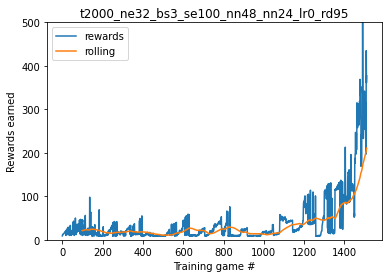

In [70]:
agent, history = train("CartPole-v1", env_params, agent_params)

In [71]:
agent.Q.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 48)                240       
                                                                 
 dense_91 (Dense)            (None, 24)                1176      
                                                                 
 dense_92 (Dense)            (None, 2)                 50        
                                                                 
Total params: 1,466
Trainable params: 1,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# !zip -r /content/t20000_ne10_bs16.zip /content/dqn_dqn_models/t20000_ne10_bs16

In [72]:
def test(env_name: str, agent: Agent, agent_path: str, episodes: int):
  if not agent:
    agent = Agent(model_path=agent_path)
  
  envs = gym.vector.make(env_name, asynchronous=True, num_envs=episodes)
  history = []
  states, info = envs.reset()
  episode_rewards = 0

  with tqdm(total=episodes) as pbar:
    while len(history) < episodes:
      actions = agent.act(states)
      states, rewards, dones, truncs, infos = envs.step(actions)
      episode_rewards += rewards

      if np.any(dones) or np.any(truncs):
        for i in range(episodes):
          if dones[i] or truncs[i]:
            history.append(episode_rewards[i])
            episode_rewards[i] = 0
      
      pbar.update(len(history))

  return history

In [74]:
history = test("CartPole-v1", None, "/content/dqn_models/t2000_ne32_bs3_se100_nn48_nn24_lr0_rd95", 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
print(np.mean(history))
print(np.std(history))

489.7
35.170015638324635


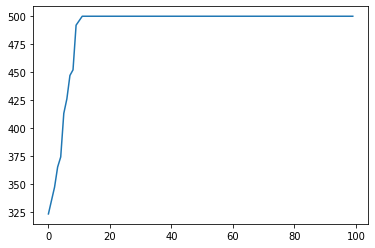

In [76]:
plt.plot(history)